In [1]:
import numpy as np
import collections
from dm_env import specs
from dm_control.rl import control
from pyquaternion import Quaternion
from scipy.interpolate import interp1d
from tcdm import suite
from tcdm.motion_util import to_quat, to_transform_mat, axis_angle_to_rot
from tcdm.envs.mujoco import physics_from_mjcf
from tcdm.envs import mj_models
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline

In [2]:
_DEFAULT_GLOBAL = Quaternion(axis=[0,0,1], angle=np.pi)
_MAX_TRIES = 10
_STEPS_PER_TRY=2000
_STOP_THRESH = 0.05
_OBJ_DELTA_THRESH = 0.001
_HUMAN_FPS = 120
_ADROIT_FPS=25
PARENTS = [None, 0, 1, 2, 0, 4, 5, 0, 7, 8, 0, 10, 11, 0, 13, 14]

In [3]:
base_env = suite.load('duck', 'inspect1'); base_env.reset()
base_physics = base_env.physics

object_model = mj_models.DuckObject()
object_name = '{}/object'.format(object_model.mjcf_model.model)
env = mj_models.TableEnv()
env.attach(mj_models.Adroit(limp=True))
env.attach(object_model)
physics = physics_from_mjcf(env)


def _init_base_robot_pose(physics, hand_joints):
    # calculate hand pose link directions
    link_directions = hand_joints[1:] - hand_joints[PARENTS[1:]]
    link_directions /= np.linalg.norm(link_directions, axis=1, keepdims=True)

    # estimate adroit hand lenths
    b_j = physics.body_poses.pos
    base_deltas = np.linalg.norm(b_j[1:] - b_j[PARENTS[1:]], 
                                 axis=1, keepdims=True)
    base_deltas = link_directions * base_deltas
    for i in range(1, len(PARENTS)):
        b_j[i] = b_j[PARENTS[i]] + base_deltas[i-1]
    return b_j


human_data = {k: v for k,v in np.load('duck_out.npz').items()}
_human_joints = np.load('base_joints.npz')['base_joints'].reshape((16, 3))
_robot_joints = _init_base_robot_pose(physics, _human_joints.copy())

# maybe refine later
_global_rot = _DEFAULT_GLOBAL.rotation_matrix.copy()

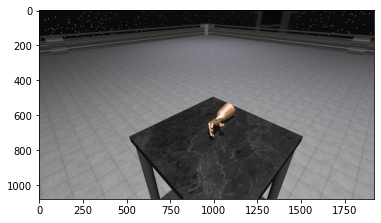

In [14]:
def _lerp(l, v1, v2):
    assert 0 <= l <= 1, 'l should be in [0,1]'
    return (1.0 - l) * v1 + l * v2


def _fk(base_translation, joint_angles):
    # initialize array of deltas between joints and parent joint
    deltas = _robot_joints.copy()
    deltas[1:] -= deltas[PARENTS[1:]]

    # set robot root joint to global_rot * root_human_joint
    human_base_joint = _human_joints[0].reshape((3, 1))
    deltas[0] = _global_rot.dot(human_base_joint)[:,0]

    # calculate rotation matrices that match joint angles
    rots = [axis_angle_to_rot(r) for r in joint_angles]
    rots = [_global_rot.dot(rots[0])] + [r for r in rots[1:]]

    # create transform matrix and perform forward kinematics
    transforms = [to_transform_mat(r, t) for r, t in zip(rots, deltas)]
    for i in range(1, len(transforms)):
        transforms[i] = transforms[PARENTS[i]].dot(transforms[i])

    # copy out final joint angle locations and transform w/ base_translation
    final_joints = np.concatenate([t[:3, 3].reshape((1, 3)) for t in transforms], 0)
    return final_joints + base_translation.reshape((1, 3))

INDEX = 2
mesh_COM = np.mean(human_data['verts_object'], axis=1)[INDEX]
fing_pos = human_data['joints_rh_gen_cnet'][INDEX].copy() - mesh_COM[None]
rot_mat = human_data['sample_rot_mats'][INDEX]
fing_pos = np.array([rot_mat.dot(f[:,None])[:,0] for f in fing_pos])
fing_pos += base_physics.named.data.xipos['duck/object'][None]

# reset the physics sim and get start_pos
physics.data.qpos[:] = 0; physics.data.qvel[:] = 0; physics.data.qpos[-4] = -1
physics.forward()
start_pos = physics.body_poses.pos

# use ik to move fingers
for l in np.linspace(0, 1, num=50):
    target = l * fing_pos + (1 - l) * start_pos
    for i, p in enumerate(target):
        physics.named.data.mocap_pos['j{}_mocap'.format(i)] = p
    physics.step()
cur_state = physics.data.qpos.copy()
plt.imshow(physics.render(camera_id=0, height=1080, width=1920))
plt.show()

In [5]:
exp_data = np.load('/home/sudeep/DexMan/trajectories/duck_inspect1.npz', allow_pickle=True)
exp_data = {k: v for k, v in exp_data.items()}
exp_data['s_0'] = exp_data['s_0'][()]

6


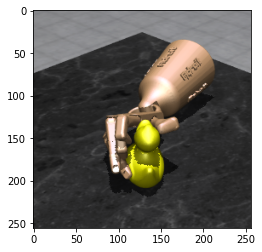

In [15]:
pg = cur_state.copy()
pg[-6:] = exp_data['s_0']['initialized']['position'][-6:]

physics.data.qpos[:] = pg
physics.forward()
for i, p in enumerate(physics.body_poses.pos):
    physics.named.data.mocap_pos['j{}_mocap'.format(i)] = p
for _ in range(150):
    physics.step()
print(physics.n_hand_contacts)
plt.imshow(physics.render(camera_id=1, height=256, width=256))

In [16]:
out_pos = pg.astype(np.float32).copy()
learned_pg = dict(position=out_pos, velocity=np.zeros_like(out_pos))
exp_data['s_0']['learned'] = learned_pg
np.savez('/home/sudeep/DexMan/trajectories/duck_inspect1.npz', **exp_data)

from dm_control.mujoco import engine
import cv2
cam = engine.MovableCamera(physics, height=1024, width=1024)
out_pg = out_pos.copy()

[-0.00295674  0.0003374   0.05194607]


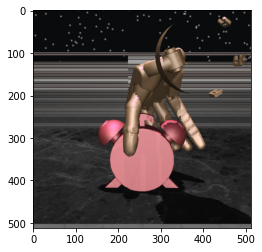

In [236]:
physics.data.qpos[:] - out_pg.copy()
physics.data.qpos[-1] = np.pi
physics.forward()
xyz = physics.named.data.xipos['alarmclock/object']
print(xyz)
cam.set_pose(xyz + [0,0,0.05], 0.7, 90, -10)

img = cv2.resize(cam.render(), (512, 512), interpolation=cv2.INTER_AREA)
# cv2.imwrite('pg_render2.png', img[:,:,::-1])
plt.imshow(img)

(16, 3)


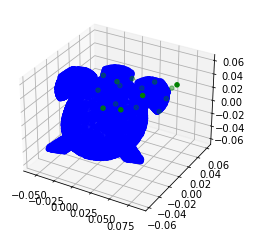

In [30]:
fig = plt.figure()
ax = plt.axes(projection='3d')

human_pos = human_data['joints_rh_gen_cnet'][INDEX]
rot_mat = human_data['sample_rot_mats'][INDEX]
human_pos = np.array([rot_mat.dot(h[:,None])[:,0] for h in human_pos])
print(human_pos.shape)

obj = human_data['verts_object'][INDEX]
obj = np.array([rot_mat.dot(o[:,None])[:,0] for o in obj])
obj = np.array(obj)

ax.scatter3D(obj[:,0], obj[:,1], obj[:,2], color='blue')
ax.scatter3D(human_pos[:,0], human_pos[:,1], human_pos[:,2], color='green')
# ax.scatter3D(mesh_COM[0], mesh_COM[1], mesh_COM[2], color='red')
plt.show()

[[-0.00043476 -0.0008486   0.05169547]]
[[-0.00351359  0.00243341 -0.00164383]]
